In [1]:
import astropy
from scipy.optimize import minimize, curve_fit
from gaia_tools import query
import emcee
import corner
from galpy.util import bovy_plot
from scipy.interpolate import CubicSpline
from galpy.util import bovy_coords, bovy_plot
import pandas

from misc import ncount,bootstrap
from random import randint

import warnings
warnings.simplefilter("ignore")

import matplotlib.colors as mcolors

%pylab inline

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Populating the interactive namespace from numpy and matplotlib


# Positions and Velocity of Gaia DR2 stars in Selected colour range for WendyM2M

This is a modified version of Morgan Bennett's VWwaves-GaiaDR2, https://github.com/morganb-phys/VWaves-GaiaDR2

Calculates the number count in the solar neighbourhood. The code also computes the sun's vertical position, zsun, by fitting a two component model to the number counts for different absolute magnitude-colour bins.

We start by choosing what cuts to make on the colours and magnitudes of our samples. To do this, we download a sample set of stars from the solar neighbourhood. We also nickname the query so that the output is not deleted when the cache is cleared weekly.

In [2]:
bprpMg_query='''SELECT -5*LOG(1000/parallax)/LOG(10)+5+phot_g_mean_mag AS mg, bp_rp FROM gaiadr2.gaia_source
WHERE parallax_over_error > 10
AND phot_g_mean_flux_over_error>50
AND phot_rp_mean_flux_over_error>20
AND phot_bp_mean_flux_over_error>20
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND visibility_periods_used>8
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
AND parallax > 4'''

out= query.query(bprpMg_query,local=False)
query.cache.nickname(bprpMg_query,'cmd_query')

True

We then use the number counts as a function of magnitude for different colour bins to fit a Gaussian distribution to the main sequence peak. These determin the different colour-magnitude bins used throughout the analysis.

In [3]:
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
  
def findbin(mag,around):
    y,x= histogram(mag,bins=101)
    x= [(x[i]+x[i+1])/2. for i in range(101)]
    popt,pcov = curve_fit(gaus,x[argmax(y)-around[0]:argmax(y)+around[1]],y[argmax(y)-around[0]:argmax(y)+around[1]],p0=[350000.,x[argmax(y)],1.])

    xmodel= linspace(-3,15,10000)
    mean= popt[1]
    var= abs(popt[2])
    
    return [round(mean-2.*var,2),round(mean+2.*var,2)]

mg_cmd= out['mg']; bprp_cmd= out['bp_rp']
print('number of stars=',len(mg_cmd))
bprp_edges= arange(0.7,2.1+0.1,0.1)
Mg_edges= zeros((len(bprp_edges)-1,2))

for i in range(len(bprp_edges)-1):
    a= [5,7] if (i<13) else [17,17]
    if (i>16):
        a=[31,31]
    
    Mg_edges[i]= findbin(mg_cmd[(bprp_cmd>bprp_edges[i])*(bprp_cmd<bprp_edges[i+1])],around=a)
    print('Colour ID, mag limit=', i, Mg_edges[i])

number of stars= 2254577
Colour ID, mag limit= 0 [3.3  4.96]
Colour ID, mag limit= 1 [3.89 5.49]
Colour ID, mag limit= 2 [4.62 5.84]
Colour ID, mag limit= 3 [5.15 6.18]
Colour ID, mag limit= 4 [5.57 6.48]
Colour ID, mag limit= 5 [5.94 6.77]
Colour ID, mag limit= 6 [6.26 7.03]
Colour ID, mag limit= 7 [6.55 7.3 ]
Colour ID, mag limit= 8 [6.81 7.58]
Colour ID, mag limit= 9 [7.07 7.85]
Colour ID, mag limit= 10 [7.31 8.16]
Colour ID, mag limit= 11 [7.54 8.48]
Colour ID, mag limit= 12 [7.76 8.82]
Colour ID, mag limit= 13 [7.97 9.19]
Colour ID, mag limit= 14 [8.18 9.58]


Next, use this bins to query the Gaia arxiv for the positions of all the stars. Again, the query nickname means that we only have to actually query the archive once, and after that it is saved in our cache. We will do this only for the selected colour bin.

In [4]:
cid = 1
print(' Selected colour bin ID and colour range =', cid, np.round(bprp_edges[cid], 2), np.round(bprp_edges[cid+1], 2))
print(' Absolute magnitude range =', Mg_edges[cid, 0], Mg_edges[cid, 1])

 Selected colour bin ID and colour range = 1 0.8 0.9
 Absolute magnitude range = 3.89 5.49


In [5]:
i=cid
queries="""SELECT cos(RADIANS(b))*(1/parallax)*cos(RADIANS(l)) AS x, 
cos(RADIANS(b))*(1/parallax)*sin(RADIANS(l)) AS y, 
(1/parallax)*sin(RADIANS(b)) AS z,
radial_velocity, radial_velocity_error, phot_g_mean_mag, bp_rp,
ra, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error
FROM gaiadr2.gaia_source
WHERE phot_g_mean_mag BETWEEN 7 AND 17
AND (1/parallax)*cos(RADIANS(b)) < 0.25 
AND parallax_over_error > 5
AND bp_rp BETWEEN {0:.2f} AND {1:.2f}
AND -5*LOG(1000/parallax)/LOG(10)+5+phot_g_mean_mag BETWEEN {2:.1f} AND {3:.1f}"""\
          .format(bprp_edges[i],
                  bprp_edges[i+1],
                  Mg_edges[i,0],
                  Mg_edges[i,1])
print('Generate Query for Colour ID=', cid)
print(queries)

# Output from the queries
out= [None]
out= query.query(queries,local=False)
# X,Y,Z positions for the different colour bins
pos = [None]
pos = array([out['x'],out['y'],out['z']])

Generate Query for Colour ID= 1
SELECT cos(RADIANS(b))*(1/parallax)*cos(RADIANS(l)) AS x, 
cos(RADIANS(b))*(1/parallax)*sin(RADIANS(l)) AS y, 
(1/parallax)*sin(RADIANS(b)) AS z,
radial_velocity, radial_velocity_error, phot_g_mean_mag, bp_rp,
ra, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error
FROM gaiadr2.gaia_source
WHERE phot_g_mean_mag BETWEEN 7 AND 17
AND (1/parallax)*cos(RADIANS(b)) < 0.25 
AND parallax_over_error > 5
AND bp_rp BETWEEN 0.80 AND 0.90
AND -5*LOG(1000/parallax)/LOG(10)+5+phot_g_mean_mag BETWEEN 3.9 AND 5.5


Check the number of stars.

In [6]:
print('Total number of sample =', len(out))
print('Number of sample with radial velocity=', len(out[out['radial_velocity_error']>0.0]))
indx = np.where(out['radial_velocity_error']>0.0)

Total number of sample = 205688
Number of sample with radial velocity= 121475


Computing U, V, W velocities.

In [7]:
lb= bovy_coords.radec_to_lb(array(out[indx]['ra']),array(out[indx]['dec']),degree=True)
XYZ= bovy_coords.lbd_to_XYZ(lb[:,0],lb[:,1],1./out[indx]['parallax'],degree=True)
Rxy= numpy.sqrt(XYZ[:,0]**2.+XYZ[:,1]**2.)
pmllbb= bovy_coords.pmrapmdec_to_pmllpmbb(out[indx]['pmra'],out[indx]['pmdec'],
                                         out[indx]['ra'],out[indx]['dec'],degree=True)
UVW= bovy_coords.vrpmllpmbb_to_vxvyvz(out[indx]['radial_velocity'],pmllbb[:,0],pmllbb[:,1],
                                      lb[:,0],lb[:,1],1./out[indx]['parallax'],degree=True)

Plot x-y and x-z for all the data.

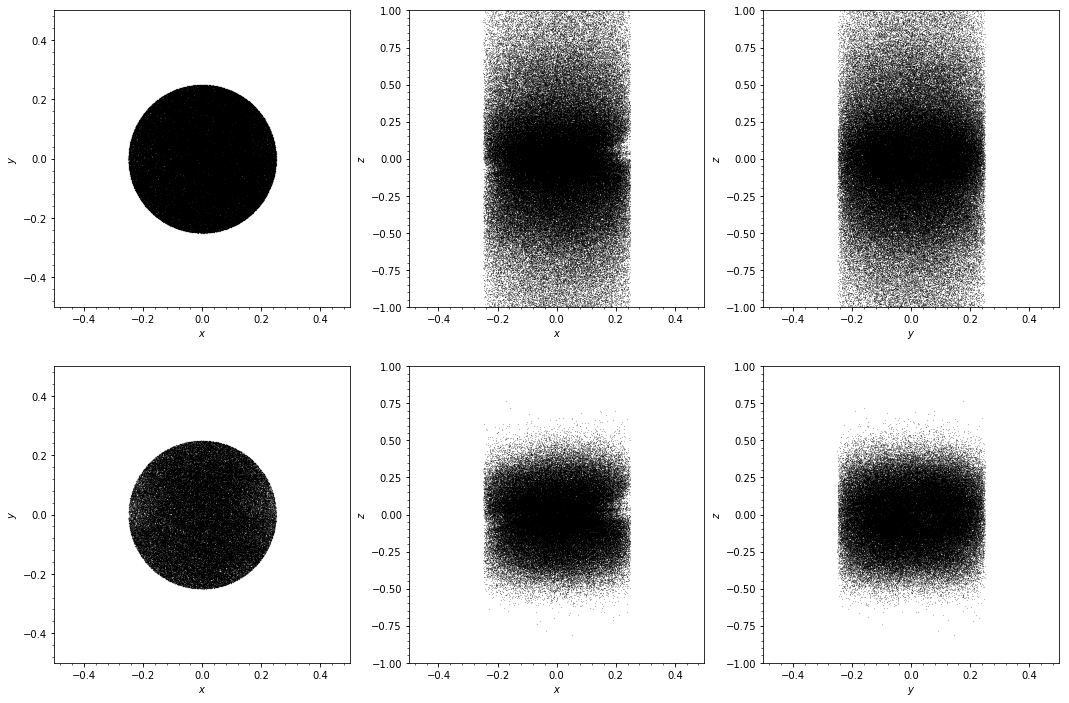

In [8]:
import h5py
import matplotlib.pyplot as plt
# plot x-y, x-z
figsize(18,12)
subplot(2,3,1)
bovy_plot.bovy_plot(pos[0],pos[1],'ko', 0.1,
                   xlabel=r'$x$',ylabel=r'$y$',
                   xrange=[-0.5, 0.5],yrange=[-0.5,0.5],gcf=True, markersize=0.1)
subplot(2,3,2)
bovy_plot.bovy_plot(pos[0],pos[2],'ko', 0.1,
                   xlabel=r'$x$',ylabel=r'$z$',
                   xrange=[-0.5, 0.5],yrange=[-1.0,1.0],gcf=True, markersize=0.1)
subplot(2,3,3)
bovy_plot.bovy_plot(pos[1],pos[2],'ko', 0.1,
                   xlabel=r'$y$',ylabel=r'$z$',
                   xrange=[-0.5, 0.5],yrange=[-1.0,1.0],gcf=True, markersize=0.1)
subplot(2,3,4)
bovy_plot.bovy_plot(XYZ[:,0],XYZ[:,1],'ko', 0.1,
                   xlabel=r'$x$',ylabel=r'$y$',
                   xrange=[-0.5, 0.5],yrange=[-0.5,0.5],gcf=True, markersize=0.1)
subplot(2,3,5)
bovy_plot.bovy_plot(XYZ[:,0],XYZ[:,2],'ko', 0.1,
                   xlabel=r'$x$',ylabel=r'$z$',
                   xrange=[-0.5, 0.5],yrange=[-1.0,1.0],gcf=True, markersize=0.1)
subplot(2,3,6)
bovy_plot.bovy_plot(XYZ[:,1],XYZ[:,2],'ko', 0.1,
                   xlabel=r'$y$',ylabel=r'$z$',
                   xrange=[-0.5, 0.5],yrange=[-1.0,1.0],gcf=True, markersize=0.1)

 N(r<0.1)= 34956


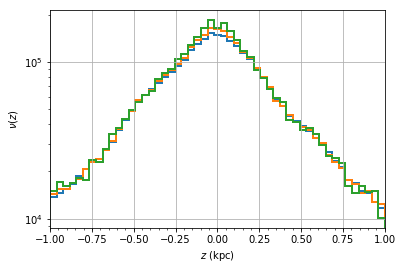

In [36]:
# stars within rxy<0.1 kpc
# indx02 = np.where(np.sqrt(pos[0]**2+pos[1]**2)<0.12)
# rlim01 = 0.2, rxylim=0.1
rxylim01 = 0.1
rxylim02 = 0.2
indx02 = np.where(np.sqrt(pos[0]**2+pos[1]**2)<rxylim02)
indx01 = np.where(np.sqrt(pos[0]**2+pos[1]**2)<rxylim01)
print(' N(r<0.1)=',np.size(indx01))
figsize(6,4)
w025 = np.ones_like(pos[2])/(0.25**2)
w02 = np.ones_like(pos[2][indx02])/(rxylim02**2)
w01 = np.ones_like(pos[2][indx01])/(rxylim01**2)
_= bovy_plot.bovy_hist(pos[2], range=(-1,1), bins=51, weights=w025,
                       xlabel=r'$z$ (kpc)',ylabel=r'$\nu(z)$',lw=2.,
                       histtype='step')
_= bovy_plot.bovy_hist(pos[2][indx02],range=(-1,1), bins=51, weights=w02,
                       overplot=True,lw=2.,
                       histtype='step')
_= bovy_plot.bovy_hist(pos[2][indx01],range=(-1,1), bins=51, weights=w01,
                       overplot=True,lw=2.,
                       histtype='step')
#_= bovy_plot.bovy_hist(pos[2], range=(-1,1), bins=51, 
#                       xlabel=r'$z$ (kpc)',ylabel=r'$\nu(z)$',lw=2.,
#                       histtype='step')
#_= bovy_plot.bovy_hist(pos[2][indx02],range=(-1,1), bins=51, 
#                       overplot=True,lw=2.,
#                       histtype='step')
#_= bovy_plot.bovy_hist(pos[2][indx01],range=(-1,1), bins=51, 
#                       overplot=True,lw=2.,
#                       histtype='step')


plt.grid(True)
gca().set_yscale('log')

Only keep stars within dxylim kpc projected onto the plane:

In [29]:
# dxy distance limit
dxylim = 0.1
# for position data
Rxypos = np.sqrt(pos[0]**2+pos[1]**2)
pindxryx= (Rxypos < dxylim)
print(' number of stars within the cylinder of Rxy<',dxylim,' kpc=',np.size(Rxypos[pindxryx]))
# for position with RVS data
vindxrxy= (Rxy < dxylim)
print(' number of stars with RVS data within the cylinder of Rxy<',dxylim,' kpc=',np.size(Rxy[vindxrxy]))

 number of stars within the cylinder of Rxy< 0.012  kpc= 492
 number of stars with RVS data within the cylinder of Rxy< 0.012  kpc= 303


Plot x-y, x-z and y-z for the selected stars. 

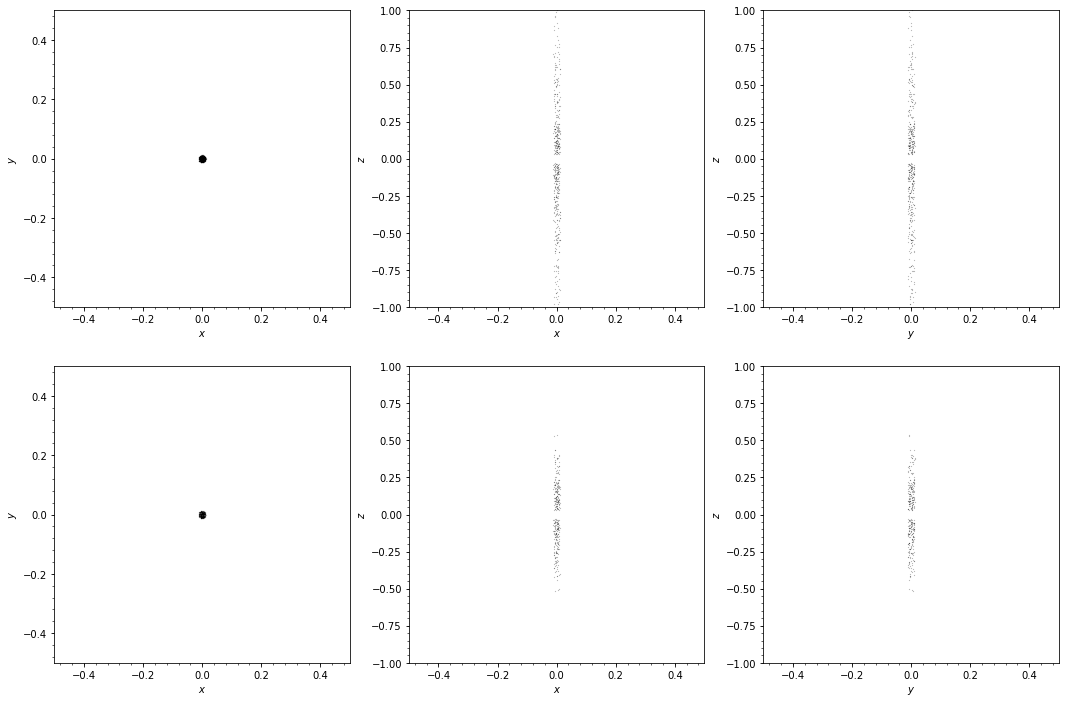

In [30]:
import h5py
import matplotlib.pyplot as plt
# plot x-y, x-z
figsize(18,12)
subplot(2,3,1)
bovy_plot.bovy_plot(pos[0][pindxryx],pos[1][pindxryx],'ko', 0.1,
                   xlabel=r'$x$',ylabel=r'$y$',
                   xrange=[-0.5, 0.5],yrange=[-0.5,0.5],gcf=True, markersize=0.1)
subplot(2,3,2)
bovy_plot.bovy_plot(pos[0][pindxryx],pos[2][pindxryx],'ko', 0.1,
                   xlabel=r'$x$',ylabel=r'$z$',
                   xrange=[-0.5, 0.5],yrange=[-1.0,1.0],gcf=True, markersize=0.1)
subplot(2,3,3)
bovy_plot.bovy_plot(pos[1][pindxryx],pos[2][pindxryx],'ko', 0.1,
                   xlabel=r'$y$',ylabel=r'$z$',
                   xrange=[-0.5, 0.5],yrange=[-1.0,1.0],gcf=True, markersize=0.1)
subplot(2,3,4)
bovy_plot.bovy_plot(XYZ[vindxrxy,0],XYZ[vindxrxy,1],'ko', 0.1,
                   xlabel=r'$x$',ylabel=r'$y$',
                   xrange=[-0.5, 0.5],yrange=[-0.5,0.5],gcf=True, markersize=0.1)
subplot(2,3,5)
bovy_plot.bovy_plot(XYZ[vindxrxy,0],XYZ[vindxrxy,2],'ko', 0.1,
                   xlabel=r'$x$',ylabel=r'$z$',
                   xrange=[-0.5, 0.5],yrange=[-1.0,1.0],gcf=True, markersize=0.1)
subplot(2,3,6)
bovy_plot.bovy_plot(XYZ[vindxrxy,1],XYZ[vindxrxy,2],'ko', 0.1,
                   xlabel=r'$y$',ylabel=r'$z$',
                   xrange=[-0.5, 0.5],yrange=[-1.0,1.0],gcf=True, markersize=0.1)

Output data only within dxylim

In [23]:
# output h5py file
# output h5py file
filename='gdr2_bb18_pos_colid'+str(cid)+'.h5'
print(' output filename=', filename)
# writing position data
with h5py.File(filename, 'w') as f:
        f.create_dataset('x', data=pos[0][pindxryx])
        f.create_dataset('y', data=pos[1][pindxryx])
        f.create_dataset('z', data=pos[2][pindxryx])
# velocity
filename='gdr2_bb18_posvz_colid'+str(cid)+'.h5'
print(' output filename=', filename)
# writing position data
with h5py.File(filename, 'w') as f:
        f.create_dataset('x',data=XYZ[vindxrxy,0])
        f.create_dataset('y',data=XYZ[vindxrxy,1])
        f.create_dataset('z',data=XYZ[vindxrxy,2])
        f.create_dataset('vz',data=UVW[vindxrxy,2])

 output filename= gdr2_bb18_pos_colid1.h5
 output filename= gdr2_bb18_posvz_colid1.h5


Colour distribution for the stars with the RVS data.

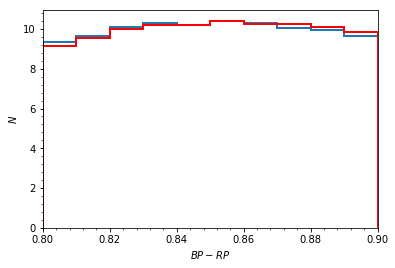

In [31]:
figsize(6,4)
bovy_plot.bovy_hist(out[indx]['bp_rp'],normed=True,xlabel=r'BP-RP',ylabel=r'N',lw=2.,histtype='step')
_ = bovy_plot.bovy_hist(out['bp_rp'],normed=True,lw=2.,histtype='step', color='r',overplot=True)

The vertical (W) velocities and their running median are:

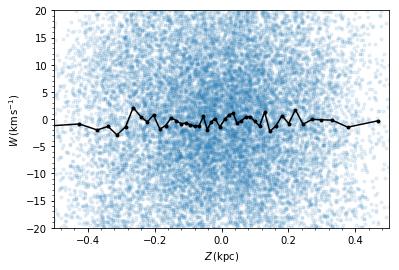

In [33]:
# vertical velocity of the Sun
vsun= 7.25
bovy_plot.bovy_plot(XYZ[indxrxy,2],UVW[indxrxy,2]+vsun,'.',alpha=0.1,
                   xrange=[-0.5,0.5],
                   yrange=[-20.,20.],
                   xlabel=r'$Z\,(\mathrm{kpc})$',
                   ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')   
sindx= numpy.argsort(XYZ[indxrxy,2])
wind= 500
showskip= wind
running_median_gaia= pandas.DataFrame(UVW[indxrxy,2][sindx]+vsun)\
        .rolling(window=wind,center=True,min_periods=wind//2)\
        .apply(lambda x: numpy.nanmedian(x),raw=True)
plot(XYZ[indxrxy,2][sindx][::showskip],running_median_gaia[::showskip],
     'k.-')

Check density at different z. (Still testing...)

 z range= -0.5 -0.4
 z range= -0.4 -0.30000000000000004
 z range= -0.3 -0.19999999999999998
 z range= -0.19999999999999996 -0.09999999999999995
 z range= -0.09999999999999998 2.7755575615628914e-17
 z range= 0.0 0.1
 z range= 0.10000000000000009 0.2000000000000001
 z range= 0.20000000000000007 0.30000000000000004
 z range= 0.30000000000000004 0.4
 z range= 0.4 0.5
 z range= 0.5 0.6


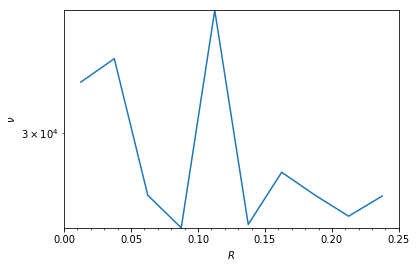

In [26]:
zmin =-0.5
zmax =0.5
nzbin = 10
dz = (zmax-zmin)/nzbin
rpos = np.sqrt(pos[0]**2+pos[1]**2)
rmin = 0.0
rmax = 0.25
nrbin = 10
ndenrz = np.zeros((nzbin+1, nrbin))
for iz in range(nzbin+1):
    zlow = zmin+iz*dz
    zhigh = zlow+dz
    print(' z range=', zlow, zhigh)
    indxz = np.where((pos[2]>=zlow) & (pos[2]<zhigh))
    hist, bin_edges = np.histogram(rpos[indxz], nrbin, range=(rmin, rmax))
    ndenrz[iz,:] = hist/(np.pi*((bin_edges[1:nrbin+1])**2-bin_edges[0:nrbin]**2))
    if iz:
        rbin = 0.5*(bin_edges[0:nrbin]+bin_edges[1:nrbin+1])

# plot
densmin=0.0
figsize(6,4)
for iz in range(nzbin+1):
    if iz:
        bovy_plot.bovy_plot(rbin, ndenrz[iz,:],'-',semilogy=True,gcf=True,
                   xlabel=r'$R$',ylabel=r'$\nu$',
                   xrange=[rmin, rmax])
    else:
        bovy_plot.bovy_plot(rbin, ndenrz[iz,:],'-',semilogy=True,gcf=True,
                   overplot=True)